In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
from scipy import optimize

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
df_bl23 = pd.read_csv('./Données/baseline_23_c_light_curve_data.csv')
df_bl24 = pd.read_csv('./Données/baseline_24_c_light_curve_data.csv')
df_obs_pri_r = pd.read_csv('./Données/obs_pri_r_c_light_curve_data.csv')
df_obs_sec_g = pd.read_csv('./Données/obs_sec_g_c_light_curve_data.csv')
df_obs_sec_r = pd.read_csv('./Données/obs_sec_r_c_light_curve_data.csv')

column_names = df_bl23.columns.tolist()
print(column_names)
print(df_bl23['filter'][0])
print(df_bl24['filter'][0])

['observation_date', 'target_intensity', 'reference_intensity', 'normalized_intensity', 'filter']
r'
r'


In [4]:
def mjd_conversion(mjd_arr):
    return Time(mjd_arr, format='jd').iso


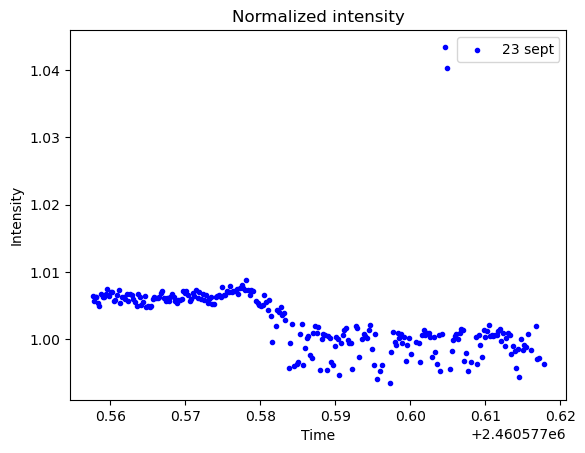

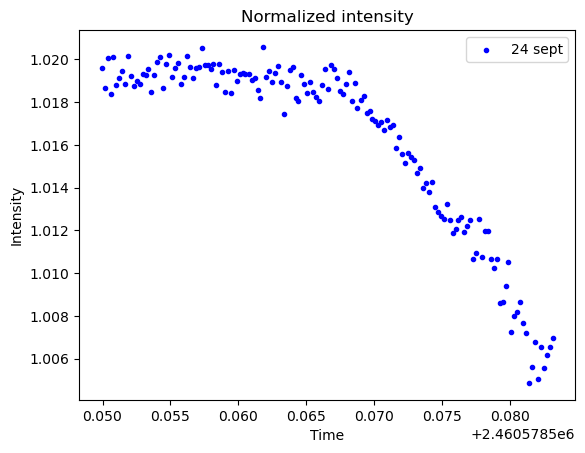

In [5]:
def plot_wrapper(data_array, title, x_lbl, y_lbl):
    for line in data_array:
        plt.scatter(line[0], line[1], label=line[2], color=line[3], marker=line[4])
    plt.title(title)
    plt.xlabel(x_lbl)
    plt.ylabel(y_lbl)
    plt.legend(loc="upper right")
    plt.show()

x_bl_23 = df_bl23['observation_date'].to_numpy()
y_bl_23 = 1/df_bl23['normalized_intensity'].to_numpy()

x_bl_24 = df_bl24['observation_date'].to_numpy()
y_bl_24 = 1/df_bl24['normalized_intensity'].to_numpy()

plot_wrapper([[x_bl_23, y_bl_23, '23 sept', 'blue', '.']],
             'Normalized intensity', 'Time', 'Intensity')

plot_wrapper([[x_bl_24, y_bl_24, '24 sept', 'blue', '.']],
             'Normalized intensity', 'Time', 'Intensity')

mean_bl_23=np.mean(y_bl_23)
std_bl_23=np.std(y_bl_23)

mean_bl_24=np.mean(y_bl_24)
std_bl_24=np.std(y_bl_24)

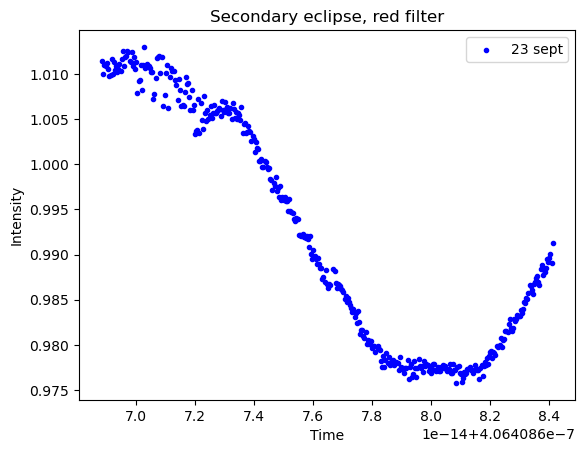

In [6]:
x_sec_r = 1/df_obs_sec_r['observation_date'].to_numpy()
y_sec_r = 1/df_obs_sec_r['normalized_intensity'].to_numpy()

plot_wrapper([[x_sec_r, y_sec_r, '23 sept', 'blue', '.']],
             'Secondary eclipse, red filter', 'Time', 'Intensity')

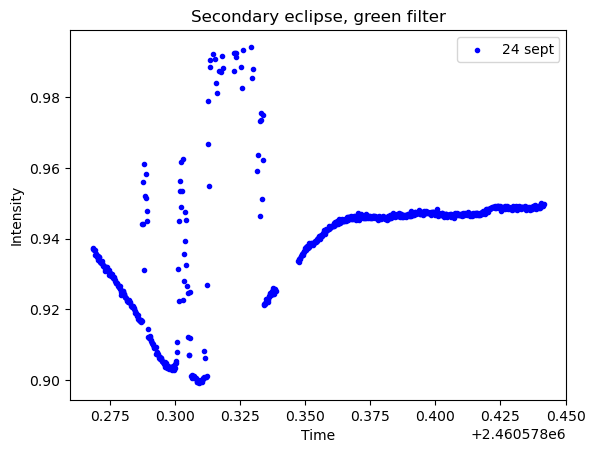

In [7]:
x_sec_g = df_obs_sec_g['observation_date'].to_numpy()
y_sec_g = 1/(df_obs_sec_g['normalized_intensity'].to_numpy())

plot_wrapper([[x_sec_g, y_sec_g, '24 sept', 'blue', '.']],
             'Secondary eclipse, green filter', 'Time', 'Intensity')

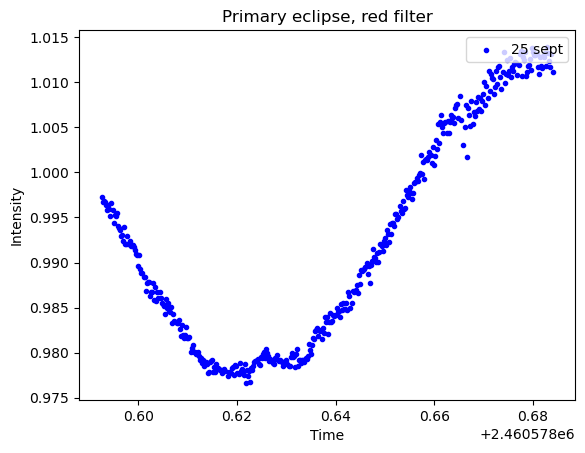

In [8]:
x_pri_r = df_obs_pri_r['observation_date'].to_numpy()
y_pri_r = 1/(df_obs_pri_r['normalized_intensity'].to_numpy())

plot_wrapper([[x_pri_r, y_pri_r, '25 sept', 'blue', '.']],
             'Primary eclipse, red filter', 'Time', 'Intensity')

In [9]:
def fft_wrapper(x_arr, y_arr):
    fs = 1/(x_arr[1]-x_arr[0])
    foufou = np.fft.fft(y_arr-np.mean(y_arr))
    freqs = np.fft.fftfreq(len(x_arr),d=fs)
    spectrum = np.abs(foufou)
    return freqs, spectrum

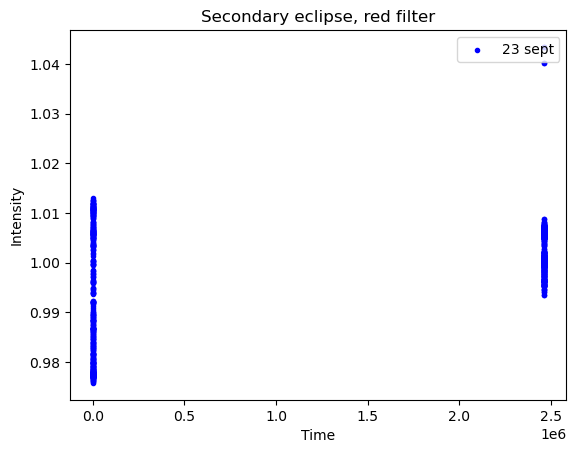

In [10]:
x_sec_tot_r = np.hstack((x_bl_23-0.279, x_sec_r, x_bl_23-0.121))
y_sec_tot_r = np.hstack((y_bl_23, y_sec_r, y_bl_23))

# Ne fonctionne pas tel quel, je travaillerai dessus si jamais on décide d'utiliser les baselines pour analyser le signal
#plot_wrapper([[x_sec_tot_r, y_sec_tot_r, '23 sept', 'blue', '.']],
#             'Secondary eclipse, red filter', 'Time', 'Intensity')


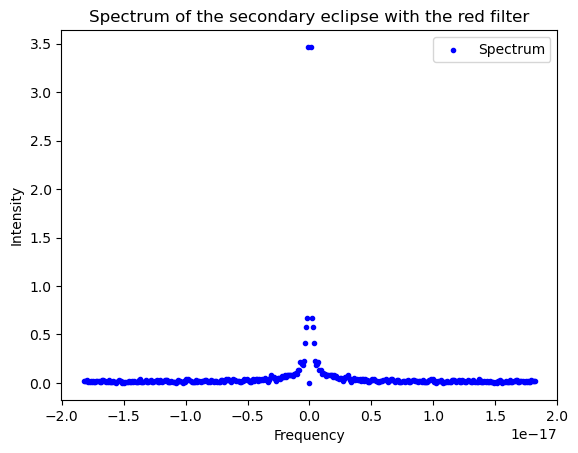

In [11]:
freqs_sec_r, spectrum_sec_r = fft_wrapper(x_sec_r, y_sec_r)

plot_wrapper([[freqs_sec_r, spectrum_sec_r, 'Spectrum', 'blue', '.']],
             'Spectrum of the secondary eclipse with the red filter', 'Frequency', 'Intensity')

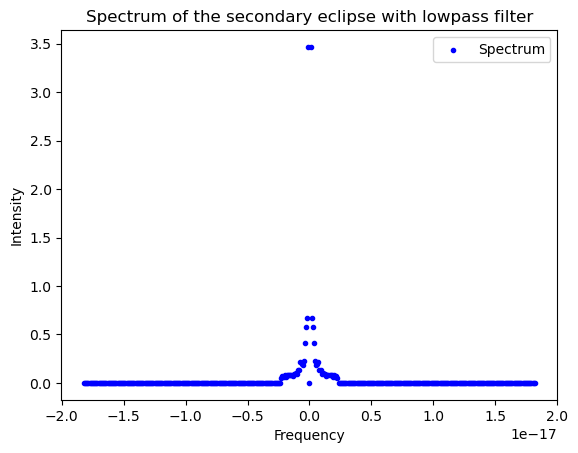

In [12]:
cutoff = 25
filtered_sec_r = spectrum_sec_r[:]
filtered_sec_r[cutoff+1:-cutoff] = 0

plot_wrapper([[freqs_sec_r, filtered_sec_r, 'Spectrum', 'blue', '.']],
             'Spectrum of the secondary eclipse with lowpass filter', 'Frequency', 'Intensity')

C:\Users\jiyan\anaconda3\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\jiyan\anaconda3\lib\site-packages\matplotlib\collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


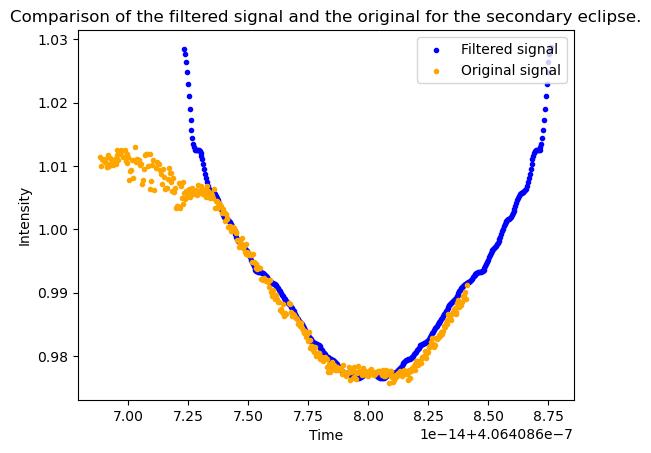

In [13]:
plot_wrapper([[x_sec_r+0.35e-14, np.fft.ifft(spectrum_sec_r)+np.mean(y_sec_r), 'Filtered signal', 'blue', '.'],
             [x_sec_r, y_sec_r, 'Original signal', 'orange', '.']],
             'Comparison of the filtered signal and the original for the secondary eclipse.', 'Time', 'Intensity')

In [14]:
# Credits: https://gist.github.com/ruoyu0088
def segments_fit(X, Y, count):
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)

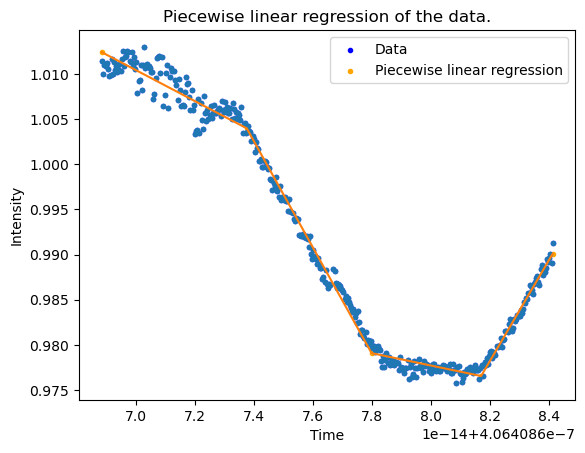

In [15]:
fx, fy = segments_fit(x_sec_r, y_sec_r, 4)

xd = np.linspace(x_sec_r[0], x_sec_r[-1], 100)
plt.plot(x_sec_r, y_sec_r, ".")
plt.plot(fx, fy)

plot_wrapper([[x_sec_r, y_sec_r, 'Data', 'blue', '.'],
             [fx, fy, 'Piecewise linear regression', 'orange', '.']],
             'Piecewise linear regression of the data.', 'Time', 'Intensity')